In [812]:
import requests
from bs4 import BeautifulSoup as bs
import time
import pandas as pd
from collections import Counter
import seaborn as sns
from sklearn.linear_model import LinearRegression
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import statsmodels.api as sm
from collections import Counter
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
import sklearn.metrics as metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

In [94]:
def mojo_movie_dict_maker(num=1000):
    """exploits the current html structure of boxofficemojo.com 
    to compile a dictionary of the top 1000 top grossing movies 
    domestically where the key represents the rank of the movie, 
    and the value represents the movie at that rank"""
    offset_list = [val for val in range(0,num-199,200)]
    top_movie_dict = dict()
    top_BO_dict = dict()
    movie_slot = 0
    url_list = []
    for offset in offset_list:
        url = f"https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset={str(offset)}"
        response = requests.get(url) 
        time.sleep(2)
        page_html = response.text
        soup = bs(page_html)
        stew = soup.find_all('tr')
        raw_text = [val.text for val in stew[1:]]
        raw_list = [val for val in stew[1:]]
        for ind in range(len(raw_list)):
            holdout = f"https://www.boxofficemojo.com{raw_list[ind].find('a')['href']}"
            url_list.append(holdout.split('?')[0]+'credits/?ref_=bo_tt_tab#tabs')
        for entry in raw_text:
            movie_slot += 1
            top_BO_dict[movie_slot] = entry.split('$')[1][:-4].replace(',','')
            if movie_slot == 1000:
                top_movie_dict[movie_slot] = entry.split('$')[0][len(str(movie_slot))+1:]
            else:
                top_movie_dict[movie_slot] = entry.split('$')[0][len(str(movie_slot)):]
        
    return top_movie_dict, top_BO_dict, url_list
            
        

In [95]:
top_movie_dict, top_BO_dict, movie_url_list = mojo_movie_dict_maker(1000)

In [238]:
# test = pd.DataFrame(master_dict)

,top_movies,domestic_BO,actor_1,age_1,x_1,actor_2,age_2,x_2
1,Star Wars: Episode VII - The Force Awakens,936662225,Daisy Ridley,29,2,John Boyega,None,1
2,Avengers: Endgame,858373000,Robert Downey Jr.,56,1,Chris Evans,40,1
3,Avatar,760507625,Sam Worthington,45,1,Zoe Saldana,43,2
4,Black Panther,700426566,Chadwick Boseman,Au,1,Michael B. Jordan,34,1
5,Avengers: Infinity War,678815482,Robert Downey Jr.,56,1,Chris Hemsworth,38,1


In [91]:
top_movie_dict[1000]

'The Mummy'

In [73]:
def actor_dict_maker(url_list):
    actor_dict1 = dict()
    actor_dict2 = dict()
    actor_links = []
    movie_slot = 0
    for url in url_list:
        movie_slot += 1
        cast_response = requests.get(url)
        time.sleep(1)
        cast_html = cast_response.text
        cast_soup = bs(cast_html)
        link_list = [link['href'] for link in cast_soup.find('table', id='principalCast').find_all('a')]
        link_list = link_list[::2]
        raw_names = [val.text for val in cast_soup.find('table', id='principalCast').find_all('a')]
        raw_names = raw_names[::2]
        clean_names = [name.replace('\n','') for name in raw_names]
        actor_dict1[movie_slot]=clean_names[0]
        actor_dict2[movie_slot]=clean_names[1]
        actor_links.append(link_list[:2])
    return actor_links
        
        

In [77]:
firstquarter = movie_url_list[:250]
secondquarter = movie_url_list[250:500]
thirdquarter = movie_url_list[500:750]
fourthquarter = movie_url_list[750:]
# actor_list = actor_dict_maker(firstquarter)
# actor_list2 = actor_dict_maker(secondquarter)
# actor_list3 = actor_dict_maker(thirdquarter)
# actor_list4 = actor_dict_maker(fourthquarter)
# actor_links = actor_dict_maker(firstquarter)
# actor_links2 = actor_dict_maker(secondquarter)
# actor_links3 = actor_dict_maker(thirdquarter)
# actor_links4 = actor_dict_maker(fourthquarter)

250

In [103]:
def actor_dict_maker(actor_list, actor_list2, actor_list3, actor_list4):
    """combines the lists of dictionaries from the prior function 
    into a single pair of dictionaries with actor_dict1 containing 
    the highest billed cast from the movie whose rank is represented
    by the key (e.g. 1-1000), and actor_dict2 is the second highest 
    billed actor"""
    actor_dict1 = dict()
    actor_dict2 = dict()
    for ind, val in enumerate(actor_list[0].values()):
        actor_dict1[ind+1]=val
        actor_dict2[ind+1]=actor_list[1][ind+1]
        actor_dict1[ind+251]=actor_list2[0][ind+1]
        actor_dict2[ind+251]=actor_list2[1][ind+1]
        actor_dict1[ind+501]=actor_list3[0][ind+1]
        actor_dict2[ind+501]=actor_list3[1][ind+1]
        actor_dict1[ind+751]=actor_list4[0][ind+1]
        actor_dict2[ind+751]=actor_list4[1][ind+1]
    return [actor_dict1, actor_dict2]


In [104]:
actor_dict_list = actor_dict_maker(actor_list, actor_list2, actor_list3, actor_list4)

In [196]:
masterlist = actor_links + actor_links2 + actor_links3 + actor_links4


In [198]:
def actor_detail_dict_maker(masterlist):
    """scrapes the age and listed gender of each actor
    from the inputted list of tuples where actor 1
    dictionaries reference the highest billed actor stats
    and actor 2 dictionaries reference the second highest billed"""
    dict_slot = 0
    actor1_age = dict()
    actor1_x = dict()
    actor2_age = dict()
    actor2_x = dict()
    for pair in masterlist:
        dict_slot += 1
        for ind, link in enumerate(pair,1):
            if ind == 1:
                actor_url = link 
                actor_response = requests.get(actor_url)
                time.sleep(1)
                actor_html = actor_response.text
                actor_soup = bs(actor_html)
                actor1_age[dict_slot] = age_scraper(actor_soup)
                actor1_x[dict_slot] = x_scraper(actor_soup)
            else:
                actor_url = link 
                actor_response = requests.get(actor_url)
                time.sleep(1)
                actor_html = actor_response.text
                actor_soup = bs(actor_html)
                actor2_age[dict_slot] = age_scraper(actor_soup)
                actor2_x[dict_slot] = x_scraper(actor_soup)
    return [actor1_age, actor1_x, actor2_age, actor2_x]

            


In [176]:
'Actor' in actor_soup.find(id='name_page_primary_professions').text


True

In [182]:
def age_scraper(actor_soup):
    """attempts to retreive the age of the actor from their imdb page bs object
    and returns a None value if the age is not listed or is listed elsewhere."""
    try:
        age = actor_soup.find(id='const_page_summary_section').find(class_="a-fixed-left-grid-col a-col-right").find(class_='a-color-secondary').parent.find('span').text.split(' ')[2][:2]
        return age
    except:
        return None

In [216]:
def x_scraper(actor_soup):
    """extracts the x-factor of the actor referenced
    in the incoming Beautiful Soup object"""
    try:
        if 'Actor' in actor_soup.find(id='name_page_primary_professions').text:
            return 1
        else:
            return 2
    except:
        return None

In [217]:
actor_detail_dict_list = actor_detail_dict_maker(actor_links)

In [219]:
actor_detail_dict_list2 = actor_detail_dict_maker(actor_links2)

In [224]:
actor_detail_dict_list3 = actor_detail_dict_maker(actor_links3)

In [225]:
actor_detail_dict_list4 = actor_detail_dict_maker(actor_links4)

In [229]:
def actor_detail_dict_maker(actor_detail_dict_list,actor_detail_dict_list2,actor_detail_dict_list3,actor_detail_dict_list4):
    """combines the lists of dictionaries from the prior function 
    into a single pair of dictionaries with actor_dict1 containing 
    the highest billed cast from the movie whose rank is represented
    by the key (e.g. 1-1000), and actor_dict2 is the second highest 
    billed actor"""
    prime_age_1 = dict()
    prime_x_1 = dict()
    prime_age_2 = dict()
    prime_x_2 = dict()
    for ind, val in enumerate(actor_detail_dict_list[0].values(),1):
        prime_age_1[ind]=val
        prime_x_1[ind]=actor_detail_dict_list[1][ind]
        prime_age_2[ind]=actor_detail_dict_list[2][ind]
        prime_x_2[ind]=actor_detail_dict_list[3][ind]
        prime_age_1[ind+250]=actor_detail_dict_list2[0][ind]
        prime_x_1[ind+250]=actor_detail_dict_list2[1][ind]
        prime_age_2[ind+250]=actor_detail_dict_list2[2][ind]
        prime_x_2[ind+250]=actor_detail_dict_list2[3][ind]
        prime_age_1[ind+500]=actor_detail_dict_list3[0][ind]
        prime_x_1[ind+500]=actor_detail_dict_list3[1][ind]
        prime_age_2[ind+500]=actor_detail_dict_list3[2][ind]
        prime_x_2[ind+500]=actor_detail_dict_list3[3][ind]
        prime_age_1[ind+750]=actor_detail_dict_list4[0][ind]
        prime_x_1[ind+750]=actor_detail_dict_list4[1][ind]
        prime_age_2[ind+750]=actor_detail_dict_list4[2][ind]
        prime_x_2[ind+750]=actor_detail_dict_list4[3][ind]
    return [prime_age_1, prime_x_1, prime_age_2, prime_x_2]

In [230]:
detail_list = actor_detail_dict_maker(actor_detail_dict_list,actor_detail_dict_list2,actor_detail_dict_list3,actor_detail_dict_list4)

In [468]:
actor1count = Counter(actor_dict_list[0].values())
actor2count = Counter(actor_dict_list[1].values())


In [350]:
def frequency_assignment(actor_dict_list):
    frequencydict1 = dict()
    frequencydict2 = dict()
    actor1count = Counter(actor_dict_list[0].values())
    actor2count = Counter(actor_dict_list[1].values())
    for ind, val in enumerate(movie_df['actor_1'],1):
        frequencydict1[ind] = actor1count[val]
    for ind, val in enumerate(movie_df['actor_2'],1):
        frequencydict2[ind] = actor2count[val]
    return [frequencydict1, frequencydict2]
        

In [351]:
frequency_dicts = frequency_assignment(actor_dict_list)

In [404]:
master_dict={'top_movies' : pd.Series(top_movie_dict), 
             'domestic_BO' : pd.Series(top_BO_dict), 
             'actor_1' : pd.Series(actor_dict_list[0]),
             'age_1' : pd.Series(detail_list[0]), 
             'x_1' : pd.Series(detail_list[1]), 
             'frequency_1' : pd.Series(frequency_dicts[0]), 
             'actor_2' : pd.Series(actor_dict_list[1]), 
             'age_2' : pd.Series(detail_list[2]), 
             'x_2' : pd.Series(detail_list[3]), 
             'frequency_2' : pd.Series(frequency_dicts[1]),
             'year_since' : pd.Series(year_dict),
            'age_at_release_1' : pd.Series(age_at_release_list[0]),
            'age_at_release_2' : pd.Series(age_at_release_list[1])}

In [405]:
movie_df = pd.DataFrame(master_dict)

In [406]:
movie_df.head()

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2
1,Star Wars: Episode VII - The Force Awakens,936662225,Daisy Ridley,29,2,3,John Boyega,None,1,3,6,23.0,NaN
2,Avengers: Endgame,858373000,Robert Downey Jr.,56,1,10,Chris Evans,40,1,4,2,54.0,38.0
3,Avatar,760507625,Sam Worthington,45,1,3,Zoe Saldana,43,2,2,12,33.0,31.0
4,Black Panther,700426566,Chadwick Boseman,Au,1,2,Michael B. Jordan,34,1,1,3,NaN,31.0
5,Avengers: Infinity War,678815482,Robert Downey Jr.,56,1,10,Chris Hemsworth,38,1,2,3,53.0,35.0


In [397]:
len(movie_df['age_1'])

1000

In [401]:

def year_adder(movie_df):
    age_at_release_1 = dict()
    age_at_release_2 = dict()
    for val in range(1,len(movie_df['age_1'])+1):
        try:
            age_at_release_1[val] = int(movie_df['age_1'][val])-movie_df['year_since'][val]
        except:
            age_at_release_1[val] = None
        try:
            age_at_release_2[val] = int(movie_df['age_2'][val])-movie_df['year_since'][val]
        except:
            age_at_release_2[val] = None
    return[age_at_release_1, age_at_release_2]
                                           

    

In [402]:
age_at_release_list = year_adder(movie_df)

In [403]:
age_at_release_list[0][1]

23

In [434]:
mean1 = movie_df['age_at_release_1'].mean()
mean2 = movie_df['age_at_release_2'].mean()
movie_df['age_at_release_1'].fillna(value=mean1, inplace=True)
movie_df['age_at_release_2'].fillna(value=mean2, inplace=True)

In [435]:
movie_df.head()

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2
1,Star Wars: Episode VII - The Force Awakens,936662225,Daisy Ridley,29,2,3,John Boyega,None,1,3,6,23.000000,37.650976
2,Avengers: Endgame,858373000,Robert Downey Jr.,56,1,10,Chris Evans,40,1,4,2,54.000000,38.000000
3,Avatar,760507625,Sam Worthington,45,1,3,Zoe Saldana,43,2,2,12,33.000000,31.000000
4,Black Panther,700426566,Chadwick Boseman,Au,1,2,Michael B. Jordan,34,1,1,3,39.276047,31.000000
5,Avengers: Infinity War,678815482,Robert Downey Jr.,56,1,10,Chris Hemsworth,38,1,2,3,53.000000,35.000000


In [465]:
target = movie_df['domestic_BO'].astype(int)
features = movie_df[['x_1','frequency_1','age_at_release_1','x_2','frequency_2','age_at_release_2']]
pairplot = movie_df[['domestic_BO','x_1','frequency_1','age_at_release_1','x_2','frequency_2','age_at_release_2']]
pairplot['domestic_BO'] = pairplot['domestic_BO'].astype(int)

<ipython-input-465-26a2d4bb639b>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pairplot['domestic_BO'] = pairplot['domestic_BO'].astype(int)


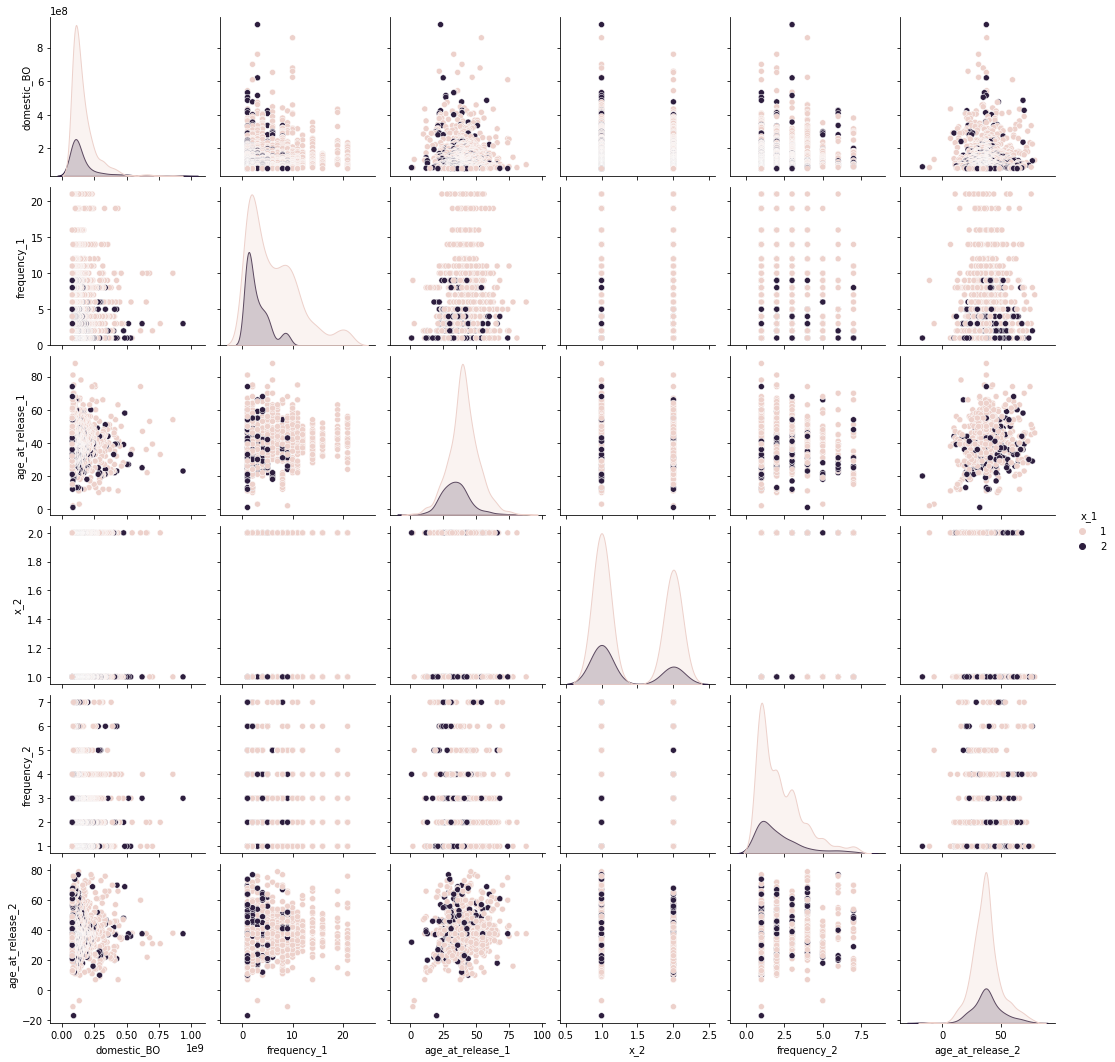

In [464]:
y = target
x = features
sns.pairplot(pairplot, hue='x_1')

In [358]:
def top_1000_years_since(num=1000):
    offset_list = [val for val in range(0,num-199,200)]
    year_dict = dict()
    movie_slot = 0
    for offset in offset_list:
        url = f"https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset={str(offset)}"
        response = requests.get(url) 
        time.sleep(2)
        page_html = response.text
        soup = bs(page_html)
        stew = soup.find_all('tr')
        raw_text = [val.text for val in stew[1:]]
        for entry in raw_text:
            movie_slot += 1
            year_dict[movie_slot] = (2021 - int(entry.split('$')[1][-4:].replace(',','')))
    return year_dict

In [359]:
year_dict = top_1000_years_since()

In [429]:
movie_df.to_csv('movie_df.csv', index=False)  

[1, 2, 3, 4]

In [423]:
def missing_age_list(movie_df):
    missing_1_list = []
    missing_2_list = []
    for val in range(1,len(movie_df['age_1'])+1):
        try:
            int(movie_df['age_1'][val])
        except:
            missing_1_list.append(movie_df['actor_1'][val])
        try:
            int(movie_df['age_2'][val])
        except:
            missing_2_list.append(movie_df['actor_2'][val])
    return [list(set(missing_1_list)), list(set(missing_2_list))]

In [424]:
missing_lists = missing_age_list(movie_df)

In [466]:
print(len(missing_lists[0]))

51


In [479]:
movie_df[movie_df['actor_1']=='Daisy Ridley']

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2
1,Star Wars: Episode VII - The Force Awakens,936662225,Daisy Ridley,29,2,3,John Boyega,None,1,3,6,23.0,37.650976
9,Star Wars: Episode VIII - The Last Jedi,620181382,Daisy Ridley,29,2,3,John Boyega,None,1,3,4,25.0,37.650976
14,Star Wars: Episode IX - The Rise of Skywalker,515202542,Daisy Ridley,29,2,3,John Boyega,None,1,3,2,27.0,37.650976


In [474]:
y = movie_df['domestic_BO']
x = movie_df[['x_1','frequency_1','x_2','frequency_2','age_at_release_1','age_at_release_2']]

In [475]:
model = LinearRegression()

In [476]:
model.fit(x,y)

LinearRegression()

In [478]:
model.coef_

array([-11957581.0970115 ,    374001.61735519,  -7711593.34708233,
         9776200.40433914,   -686770.94316868,     64349.44038519])

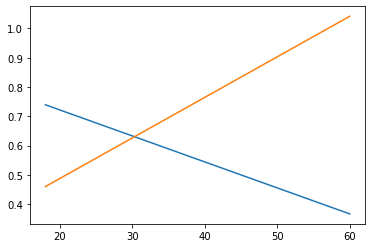

In [498]:
years = np.array([18,34,51,60])
male = np.array([.4,.75,1,.95])
female = np.array([.5,1,.4,.25])
mm,mb = np.polyfit(years, male,1)
fm, fb = np.polyfit(years,female,1)

plt.plot(years, fm*years+fb)
plt.plot(years, mm*years+mb)



def fval(age):
    fval = fm*age+fb
    return fval
def mval(age):
    mval = mm*age+mb
    return mval



In [502]:
mval(80)

1.3181708784596868

In [504]:
movie_df.head()

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2
1,Star Wars: Episode VII - The Force Awakens,936662225,Daisy Ridley,29,2,3,John Boyega,None,1,3,6,23.000000,37.650976
2,Avengers: Endgame,858373000,Robert Downey Jr.,56,1,10,Chris Evans,40,1,4,2,54.000000,38.000000
3,Avatar,760507625,Sam Worthington,45,1,3,Zoe Saldana,43,2,2,12,33.000000,31.000000
4,Black Panther,700426566,Chadwick Boseman,Au,1,2,Michael B. Jordan,34,1,1,3,39.276047,31.000000
5,Avengers: Infinity War,678815482,Robert Downey Jr.,56,1,10,Chris Hemsworth,38,1,2,3,53.000000,35.000000


In [505]:
def movie_year_stripper(num=1000):
    offset_list = [val for val in range(0,num-199,200)]
    top_year_dict = dict()
    movie_slot = 0
    for offset in offset_list:
        url = f"https://www.boxofficemojo.com/chart/top_lifetime_gross/?offset={str(offset)}"
        response = requests.get(url) 
        time.sleep(2)
        page_html = response.text
        soup = bs(page_html)
        stew = soup.find_all('tr')
        raw_text = [val.text for val in stew[1:]]
        for entry in raw_text:
            movie_slot += 1
            top_year_dict[movie_slot] = entry.split('$')[1][-4:]
    return top_year_dict


In [506]:
top_year_dict = movie_year_stripper()

In [511]:
movie_df['year_released'] = top_year_dict.values()

In [512]:
movie_df.head()

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2,year_released
1,Star Wars: Episode VII - The Force Awakens,936662225,Daisy Ridley,29,2,3,John Boyega,None,1,3,6,23.000000,37.650976,2015
2,Avengers: Endgame,858373000,Robert Downey Jr.,56,1,10,Chris Evans,40,1,4,2,54.000000,38.000000,2019
3,Avatar,760507625,Sam Worthington,45,1,3,Zoe Saldana,43,2,2,12,33.000000,31.000000,2009
4,Black Panther,700426566,Chadwick Boseman,Au,1,2,Michael B. Jordan,34,1,1,3,39.276047,31.000000,2018
5,Avengers: Infinity War,678815482,Robert Downey Jr.,56,1,10,Chris Hemsworth,38,1,2,3,53.000000,35.000000,2018


In [531]:
filter = movie_df['actor_1']=='Daisy Ridley'
print([val for val in movie_df[filter].sort_values('year_released', ascending=False).index])

[14, 9, 1]


In [532]:
testdf = movie_df.copy()

In [535]:
actor_1_list = [val for val in movie_df['actor_1']]
actor_2_list = [val for val in movie_df['actor_2']]
def frequency_at_release_calculator(actor_1_list,actor_2_list):
    releasedict1 = dict()
    releasedict2 = dict()
    for actor in set(actor_1_list):
        frequency = 0
        filter = movie_df['actor_1']==actor
        index_list = [val for val in movie_df[filter].sort_values('year_released', ascending=False).index]
        for index in index_list:
            frequency += 1
            releasedict1[index] = frequency
    for actor in set(actor_2_list):
        frequency = 0
        filter = movie_df['actor_2']==actor
        index_list = [val for val in movie_df[filter].sort_values('year_released', ascending=False).index]
        for index in index_list:
            frequency += 1
            releasedict2[index] = frequency
    return releasedict1, releasedict2
        

In [562]:
releasedict1, releasedict2 = frequency_at_release_calculator(actor_1_list, actor_2_list)
checkagain = pd.Series(releasedict1)


In [566]:
checkagain.sort_index()

pandas.core.series.Series

In [567]:
def dict_adder(dataframe, dictionary, name_of_column):
    input_series = pd.Series(dictionary)
    ordered_series = input_series.sort_index()
    dataframe[name_of_column] = ordered_series

In [568]:
dict_adder(movie_df,releasedict1,'frequency_at_release_1')

In [570]:
dict_adder(movie_df,releasedict2,'frequency_at_release_2')

In [572]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 1 to 1000
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   top_movies              1000 non-null   object 
 1   domestic_BO             1000 non-null   object 
 2   actor_1                 1000 non-null   object 
 3   age_1                   979 non-null    object 
 4   x_1                     1000 non-null   int64  
 5   frequency_1             1000 non-null   int64  
 6   actor_2                 1000 non-null   object 
 7   age_2                   953 non-null    object 
 8   x_2                     1000 non-null   int64  
 9   frequency_2             1000 non-null   int64  
 10  year_since              1000 non-null   int64  
 11  age_at_release_1        1000 non-null   float64
 12  age_at_release_2        1000 non-null   float64
 13  year_released           1000 non-null   object 
 14  frequency_at_release_1  1000 non-null   

In [592]:
movie_df.to_csv('movie_df_inter.csv', index=False)  

In [591]:
search = movie_df.nsmallest(5, 'year_released')
search

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2,year_released,frequency_at_release_1,frequency_at_release_2
246,Snow White and the Seven Dwarfs,184925486,Adriana Caselotti,Ja,2,1,Harry Stockwell,Ju,1,1,84,39.276047,37.650976,1937,1,1
215,Gone with the Wind,200852579,Clark Gable,No,1,1,Vivien Leigh,Ju,2,1,82,39.276047,37.650976,1939,1,1
928,Pinocchio,84254167,Dickie Jones,Ju,1,1,Christian Rub,Ap,1,1,81,39.276047,37.650976,1940,1,1
723,Bambi,102247150,Hardie Albright,De,1,1,Stan Alexander,None,1,1,79,39.276047,37.650976,1942,1,1
824,Cinderella,93141149,Ilene Woods,Ju,2,1,James MacDonald,Fe,1,1,71,39.276047,37.650976,1950,1,1


In [593]:
Target = movie_df.domestic_BO
Features = movie_df[['x_1', 'age_at_release_1','frequency_at_release_1','x_2','age_at_release_2','frequency_at_release_2']]

In [599]:
def gender_converter(Features):
    outdict = dict()
    for rank, actor in enumerate(Features.x_1,1):
        outdict[rank] = actor + Features.x_2[rank]
    return outdict

gendicter = gender_converter(Features)

In [611]:
Features['x_factor'] = gendicter.values()

<ipython-input-611-234d61ea7ca3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Features['x_factor'] = gendicter.values()


In [616]:
def value_dict(movie_df):
    value_1_dict = dict()
    value_2_dict = dict()
    for rank, age in enumerate(movie_df.age_at_release_1,1):
        if movie_df['x_1'][rank] == 1:
            value_1_dict[rank] = mval(age)
        else: 
            value_1_dict[rank] = fval(age)
        if movie_df['x_2'][rank] == 1:
            value_2_dict[rank] = mval(movie_df['age_at_release_2'][rank])
        else:
            value_2_dict[rank] = fval(movie_df['age_at_release_2'][rank])
    return value_1_dict, value_2_dict 
        

In [617]:
value_1_dict, value_2_dict = value_dict(movie_df)

In [619]:
Features['value_at_release_1'] = value_1_dict.values()
Features['value_at_release_2'] = value_2_dict.values()

<ipython-input-619-2ed7836340f6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Features['value_at_release_1'] = value_1_dict.values()
<ipython-input-619-2ed7836340f6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Features['value_at_release_2'] = value_2_dict.values()


In [620]:
Features.head()

,x_1,age_at_release_1,frequency_at_release_1,x_2,age_at_release_2,frequency_at_release_2,x_factor,value_at_release_1,value_at_release_2
1,2,23.000000,3,1,37.650976,3,3,0.694922,0.732113
2,1,54.000000,1,1,38.000000,1,2,0.958363,0.736943
3,1,33.000000,2,2,31.000000,2,3,0.667750,0.623971
4,1,39.276047,1,1,31.000000,1,2,0.754602,0.640072
5,1,53.000000,2,1,35.000000,1,2,0.944525,0.695427


In [621]:
scaled_features = scaler.fit_transform(Features)

In [626]:
scaled_features.shape

(1000, 9)

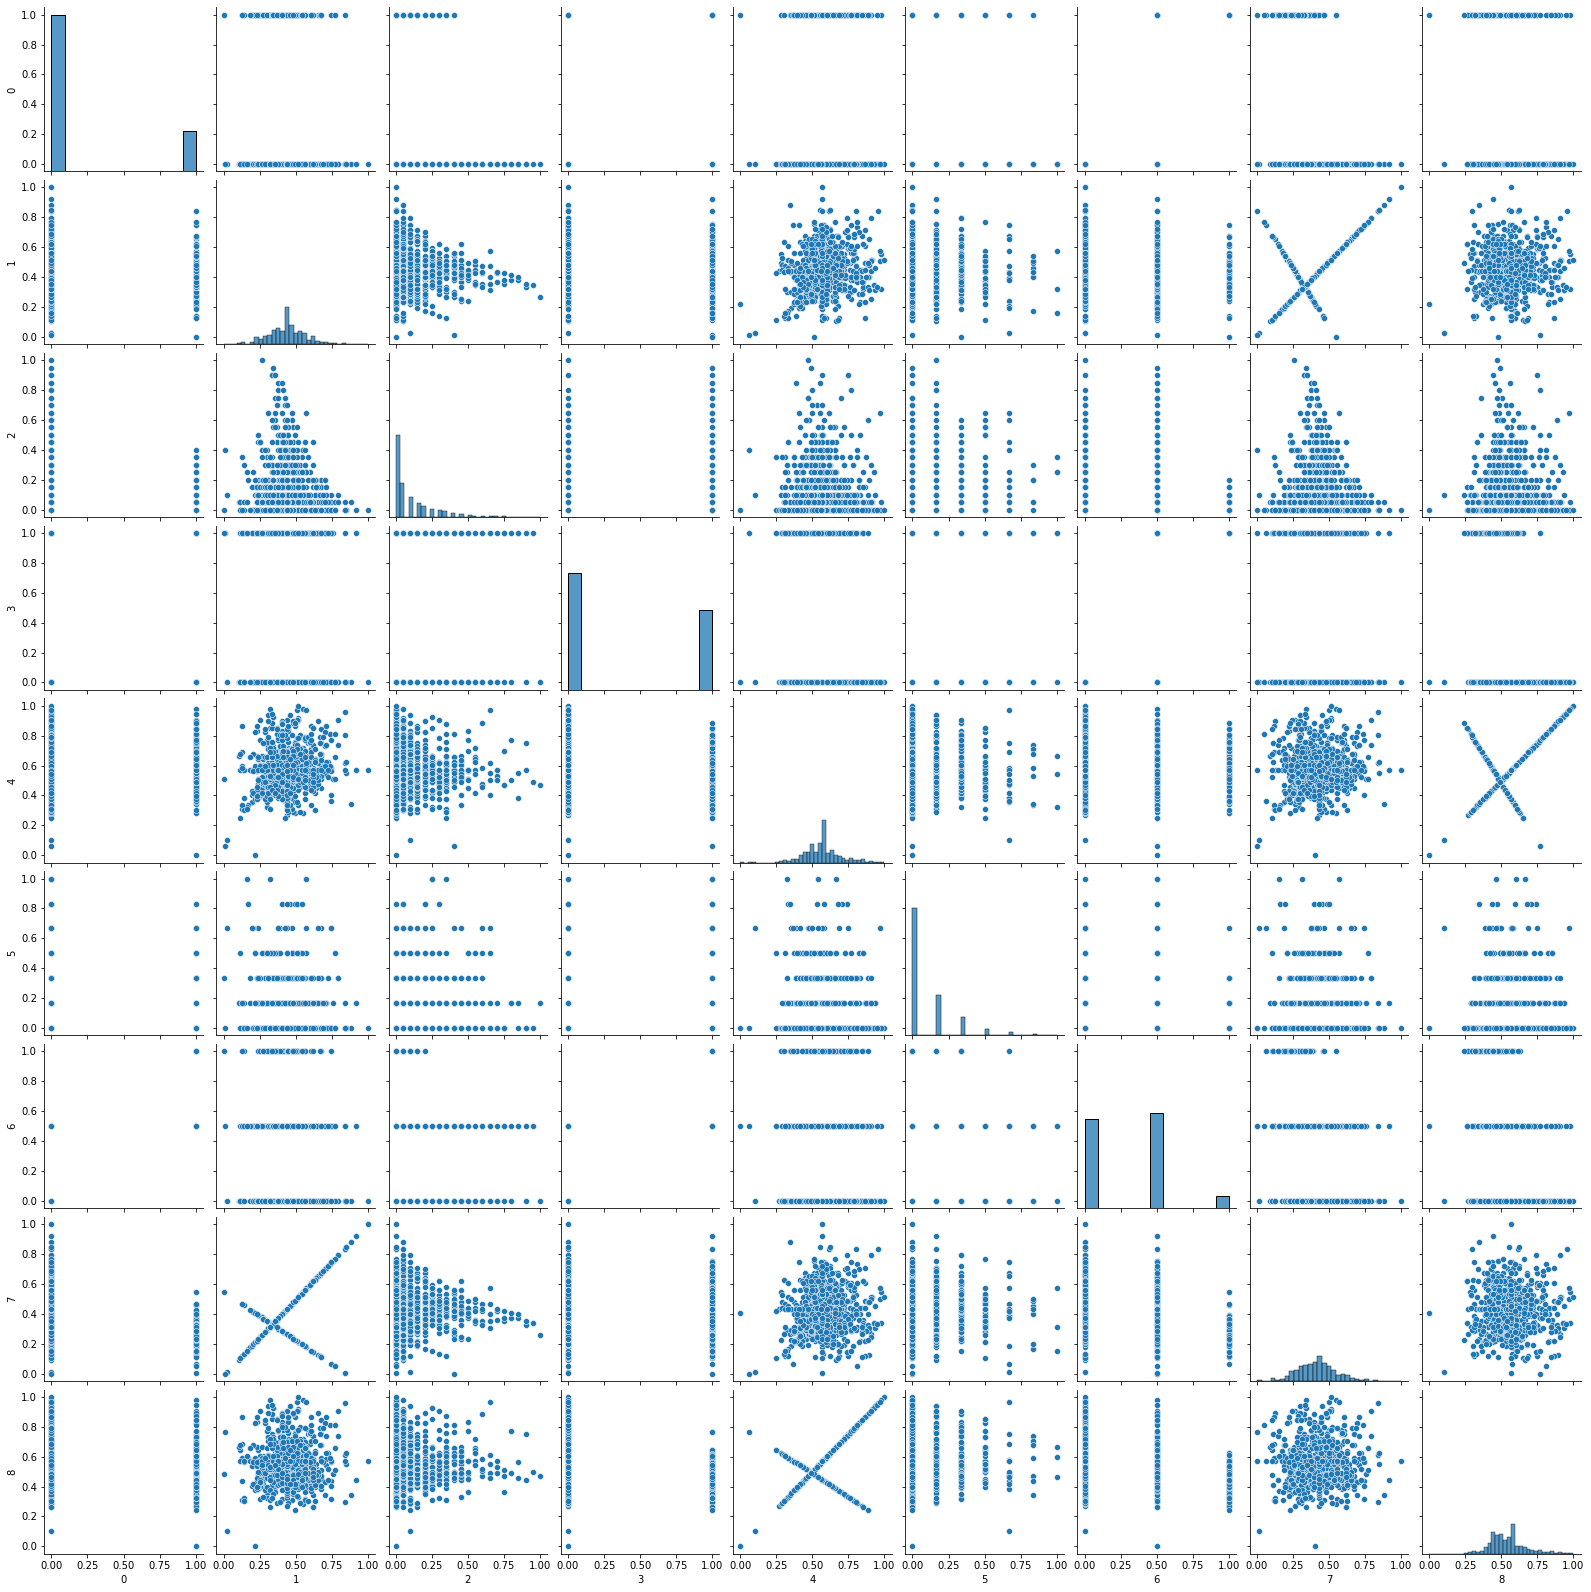

In [628]:
sns.pairplot(pd.DataFrame(scaled_features))

In [635]:
Target.head()

1    936662225
2    858373000
3    760507625
4    700426566
5    678815482
Name: domestic_BO, dtype: object

In [639]:
data = pd.DataFrame()

In [640]:
data['target'] = Target.astype(int)

In [650]:
data = data.merge(Features, left_index=True, right_index = True)

In [653]:
data.tail()

,target,x_1,age_at_release_1,frequency_at_release_1,x_2,age_at_release_2,frequency_at_release_2,x_factor,value_at_release_1,value_at_release_2
996,80277646,2,36.000000,3,1,30.0,1,3,0.579627,0.626233
997,80270227,1,29.000000,1,1,34.0,1,2,0.612395,0.681588
998,80245725,1,32.000000,12,2,23.0,1,3,0.653911,0.694922
999,80238724,1,39.276047,1,2,37.0,1,3,0.754602,0.570758
1000,80227895,1,55.000000,5,2,35.0,1,3,0.972202,0.588496


In [678]:
y = data['target'].astype(int)
x = copycheck
x = sm.add_constant(x)
model = sm.OLS(y,x, data = data)

In [679]:
fit = model.fit()

In [680]:
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.023
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     2.940
Date:                Sun, 07 Nov 2021   Prob (F-statistic):            0.00298
Time:                        20:44:38   Log-Likelihood:                -19827.
No. Observations:                1000   AIC:                         3.967e+04
Df Residuals:                     991   BIC:                         3.972e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.605e+08   2.29e+07      7.006      0.000    1.16e+08    2.05e+08
x_1                     -9.59e+06   7.63e+06     -1.256      0.209   -2.46e+07    5.39e+06
age_at_release_1       -6.945e+07   3.72e+07     -1.867      0.062   -1.42e+08    3.55e+06
frequency_at_release_1 -3.704e+07   2.04e+07     -1.812      0.070   -7.71e+07    3.07e+06
x_2                     9.216e+05   6.16e+06      0.150      0.881   -1.12e+07     1.3e+07
age_at_release_2        -3.55e+06   3.22e+07     -0.110      0.912   -6.67e+07    5.96e+07
frequency_at_release_2  5.819e+07    1.9e+07      3.064      0.002    2.09e+07    9.55e+07
x_factor               -4.334e+06   4.37e+06     -0.991      0.322   -1.29e+07    4.24e+06
value_at_release_1      1.507e+07   3.87e+07      0.390      0.697   -6.08e+07    9.09e+07
value_at_release_2      5.454e+07   3.51e+07      1.555      0.120   -1.43e+07    1.23e+08
==============================================================================
Omnibus:                      630.548   Durbin-Watson:                   0.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6756.589
Skew:                           2.787   Prob(JB):                         0.00
Kurtosis:                      14.449   Cond. No.                     1.37e+15
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 1.25e-27. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

In [666]:
Features.columns

Index(['x_1', 'age_at_release_1', 'frequency_at_release_1', 'x_2',
       'age_at_release_2', 'frequency_at_release_2', 'x_factor',
       'value_at_release_1', 'value_at_release_2'],
      dtype='object')

In [673]:
copycheck = pd.DataFrame(scaled_features, index=[val for val in range(1,1001)],columns = [val for val in Features.columns])

In [674]:
copycheck

,x_1,age_at_release_1,frequency_at_release_1,x_2,age_at_release_2,frequency_at_release_2,x_factor,value_at_release_1,value_at_release_2
1,1.0,0.252874,0.10,0.0,0.569281,0.333333,0.5,0.383296,0.569281
2,0.0,0.609195,0.00,0.0,0.572917,0.000000,0.0,0.604651,0.572917
3,0.0,0.367816,0.05,1.0,0.500000,0.166667,0.5,0.360465,0.487880
4,0.0,0.439955,0.00,0.0,0.500000,0.000000,0.0,0.433442,0.500000
5,0.0,0.597701,0.05,0.0,0.541667,0.000000,0.0,0.593023,0.541667
...,...,...,...,...,...,...,...,...,...
996,1.0,0.402299,0.10,0.0,0.489583,0.000000,0.5,0.286421,0.489583
997,0.0,0.321839,0.00,0.0,0.531250,0.000000,0.0,0.313953,0.531250
998,0.0,0.356322,0.55,1.0,0.416667,0.000000,0.5,0.348837,0.541286
999,0.0,0.439955,0.00,1.0,0.562500,0.000000,0.5,0.433442,0.447826


In [691]:
noway = copycheck[['age_at_release_1','frequency_at_release_1','frequency_at_release_2']]
noway = sm.add_constant(noway)

In [692]:
testmodel = sm.OLS(y,noway,data=data)

In [693]:
testfit = testmodel.fit()

In [694]:
testfit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.015
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     5.190
Date:                Sun, 07 Nov 2021   Prob (F-statistic):            0.00146
Time:                        20:52:24   Log-Likelihood:                -19831.
No. Observations:                1000   AIC:                         3.967e+04
Df Residuals:                     996   BIC:                         3.969e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.806e+08   1.16e+07     15.504      0.000    1.58e+08    2.03e+08
age_at_release_1       -4.757e+07   2.42e+07     -1.968      0.049    -9.5e+07   -1.28e+05
frequency_at_release_1 -2.875e+07   1.99e+07     -1.443      0.149   -6.79e+07    1.03e+07
frequency_at_release_2   6.12e+07   1.89e+07      3.230      0.001     2.4e+07    9.84e+07
==============================================================================
Omnibus:                      624.024   Durbin-Watson:                   0.033
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6476.659
Skew:                           2.761   Prob(JB):                         0.00
Kurtosis:                      14.178   Cond. No.                         9.41
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [740]:
movie_df.nsmallest(20, 'year_released')

,top_movies,domestic_BO,actor_1,age_1,x_1,frequency_1,actor_2,age_2,x_2,frequency_2,year_since,age_at_release_1,age_at_release_2,year_released,frequency_at_release_1,frequency_at_release_2
246,Snow White and the Seven Dwarfs,184925486,Adriana Caselotti,Ja,2,1,Harry Stockwell,Ju,1,1,84,39.276047,37.650976,1937,1,1
215,Gone with the Wind,200852579,Clark Gable,No,1,1,Vivien Leigh,Ju,2,1,82,39.276047,37.650976,1939,1,1
928,Pinocchio,84254167,Dickie Jones,Ju,1,1,Christian Rub,Ap,1,1,81,39.276047,37.650976,1940,1,1
723,Bambi,102247150,Hardie Albright,De,1,1,Stan Alexander,None,1,1,79,39.276047,37.650976,1942,1,1
824,Cinderella,93141149,Ilene Woods,Ju,2,1,James MacDonald,Fe,1,1,71,39.276047,37.650976,1950,1,1
883,Pineapple Express,87341380,Seth Rogen,39,1,5,James Franco,43,1,1,13,26.000000,30.000000,1953,5,1
816,Lady and the Tramp,93602326,Barbara Luddy,Ap,2,1,Larry Roberts,Ju,1,1,66,39.276047,37.650976,1955,1,1
402,One Hundred and One Dalmatians,144880014,Rod Taylor,Ja,1,1,Betty Lou Gerson,Ja,2,1,60,39.276047,37.650976,1961,1,1
722,Mary Poppins,102272727,Julie Andrews,86,2,3,Dick Van Dyke,95,1,1,57,29.000000,38.000000,1964,3,1
344,The Sound of Music,159287539,Julie Andrews,86,2,3,Christopher Plummer,Fe,1,1,56,30.000000,37.650976,1965,2,1


In [739]:
movie_df.loc(0)[883]['year_released'] = 2009

<ipython-input-739-ffdd8384f997>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movie_df.loc(0)[883]['year_released'] = 2009


In [738]:
movie_df.loc(0)[413][]

'Owen Wilson'

In [745]:
movie_df.loc(0)[246,215,928,723,824,882,816,402,722,344,632,417,691,721,680][['top_movies','x_1','x_2','year_released']]

,top_movies,x_1,x_2,year_released
246,Snow White and the Seven Dwarfs,2,1,1937
215,Gone with the Wind,1,2,1939
928,Pinocchio,1,1,1940
723,Bambi,1,1,1942
824,Cinderella,2,1,1950
882,Peter Pan,1,2,1999
816,Lady and the Tramp,2,1,1955
402,One Hundred and One Dalmatians,1,2,1961
722,Mary Poppins,2,1,1964
344,The Sound of Music,2,1,1965


In [747]:
count = Counter(Features.x_factor)

In [748]:
count

Counter({3: 485, 2: 451, 4: 64})

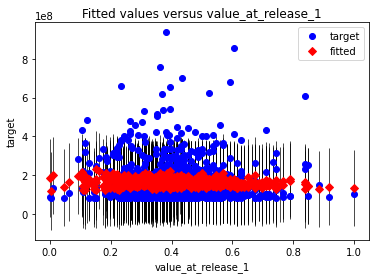

In [834]:
fig, ax = plt.subplots()
fig = sm.graphics.plot_fit(fit, 8, ax=ax)

In [772]:
followme = testfit.predict()
wanttobe = fit.predict()

In [773]:
mae1 = metrics.mean_absolute_error(y,wanttobe)
mae2 = metrics.mean_absolute_error(y,followme)


In [835]:
mae1

66780866.44680748

In [807]:
def validation(x_data,y_data,data):
    X = x_data
    Y = y_data
    
    X, X_test, Y, Y_test = train_test_split(X,Y,test_size=.2,random_state=10)
    X_train, X_val, Y_train, Y_val = train_test_split(X,Y,test_size=.25,random_state=3)
    
    model = sm.OLS(Y_train,X_train,data=data)
    validationmodel = sm.OLS(Y,X,data=data)
    fit = model.fit()
    return fit, validationmodel


In [808]:
idontknow, tralidation = validation(noway,y,data)

In [809]:
tralifit = tralidation.fit()

In [810]:
tralifit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     4.241
Date:                Tue, 09 Nov 2021   Prob (F-statistic):            0.00551
Time:                        18:25:22   Log-Likelihood:                -15863.
No. Observations:                 800   AIC:                         3.173e+04
Df Residuals:                     796   BIC:                         3.175e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   1.771e+08    1.3e+07     13.582      0.000    1.52e+08    2.03e+08
age_at_release_1       -3.809e+07   2.71e+07     -1.403      0.161   -9.14e+07    1.52e+07
frequency_at_release_1 -3.326e+07    2.2e+07     -1.515      0.130   -7.64e+07    9.85e+06
frequency_at_release_2  6.458e+07   2.09e+07      3.087      0.002    2.35e+07    1.06e+08
==============================================================================
Omnibus:                      480.714   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4361.753
Skew:                           2.641   Prob(JB):                         0.00
Kurtosis:                      13.147   Cond. No.                         9.45
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [816]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression().fit(noway,y)
scores = cross_validate(reg, noway,y,
                         scoring = ('r2', 'neg_mean_absolute_error'),
                         return_train_score=True)

In [821]:
scores['test_r2']

array([  -2.63774778,   -1.42682107,  -28.52229199, -172.06183668,
       -469.3779168 ])